In [2]:
import os
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import earthpy as et
import imageio
from datetime import datetime

In [13]:
def blur_image_plot(image, n):
    fig, ax = plt.subplots(1, n+1, figsize=(10, 10), sharex=True, sharey=True)
    print("std dev\n=======\noriginal: {}".format(image.std()))
    ax[0].imshow(image)
    for i in range(1,n+1):
        blurred_image = ndimage.gaussian_filter(image, sigma=i)
        print("blurred, sigma = {}: {}".format(i, blurred_image.std()))
        ax[i].imshow(blurred_image)
def plot_image_RGB(image):
    fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
    r = image[:, :, 0:3]
    ax[0, 0].imshow(r)
    ax[0, 0].set_title("RGB")
    r = image[:, :, 0]
    ax[0, 1].imshow(r, cmap=plt.cm.gray)
    ax[0, 1].set_title('Red')
    r = image[:, :, 1]
    ax[1, 0].imshow(r, cmap=plt.cm.gray)
    ax[1, 0].set_title('Green')
    r = image[:, :, 2]
    ax[1, 1].imshow(r, cmap=plt.cm.gray)
    ax[1, 1].set_title('Blue')
    for a in ax.ravel():
        a.set_axis_off()
    plt.tight_layout()
    plt.show()

(10000, 10000, 3) uint8


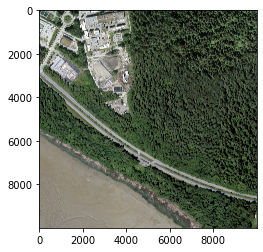

In [3]:
os.chdir(os.path.join(et.io.HOME, "ubc/capstone/orthophoto/2014"))
image = imageio.imread('483E_5454N.tif')
type(image)
print(image.shape, image.dtype)
plt.imshow(image)

## Analyze and plot image

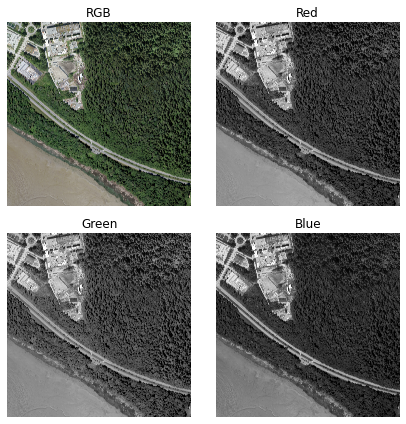

In [14]:
plot_image_RGB(image)

std dev
original: 57.35351437448725
blurred, sigma = 1: 54.40847703826589
blurred, sigma = 2: 52.82652444570227
blurred, sigma = 3: 51.948296901896
blurred, sigma = 4: 51.330094730926405


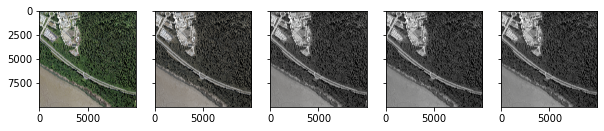

In [15]:
blur_image_plot(image,4)

## Sliding window standard deviation

In [37]:
def plot_window_stddev(n, window_size, offset):
    fig, ax = plt.subplots(n, n, figsize=(20,20), sharex=True, sharey=True)

    for y in range(offset,n+offset):
        for x in range(offset,n+offset):
            r = image[y*window_size:(y+1)*window_size, x*window_size:(x+1)*window_size, 0:3]
            ax[y-offset,x-offset].imshow(r)
            ax[y-offset,x-offset].set_title("{:.2f}".format(r.std()))

### Non-forested area

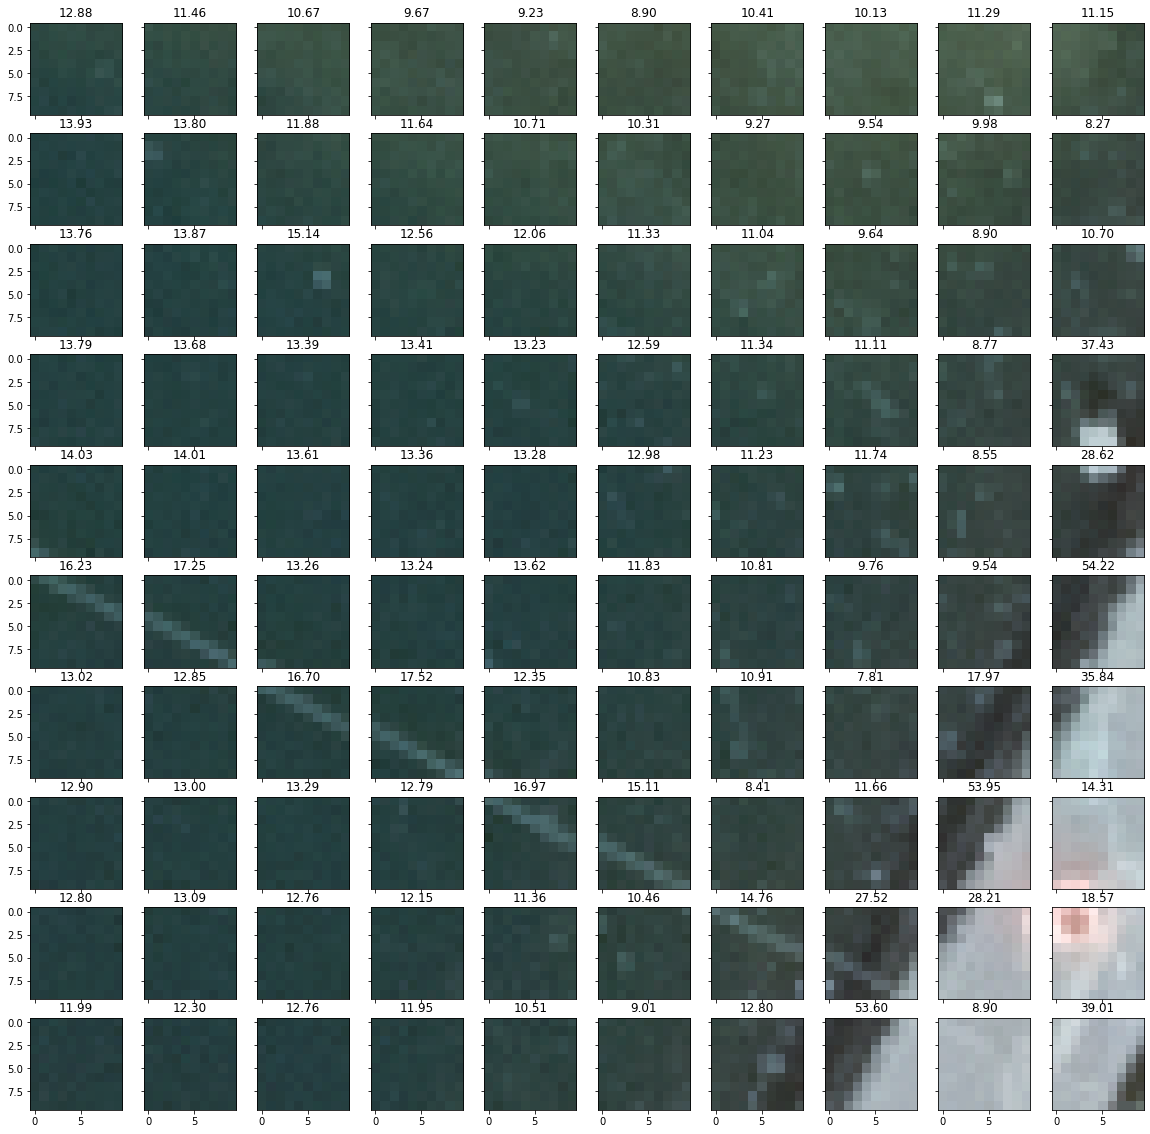

In [38]:
plot_window_stddev(10,10,0)

### Forested area

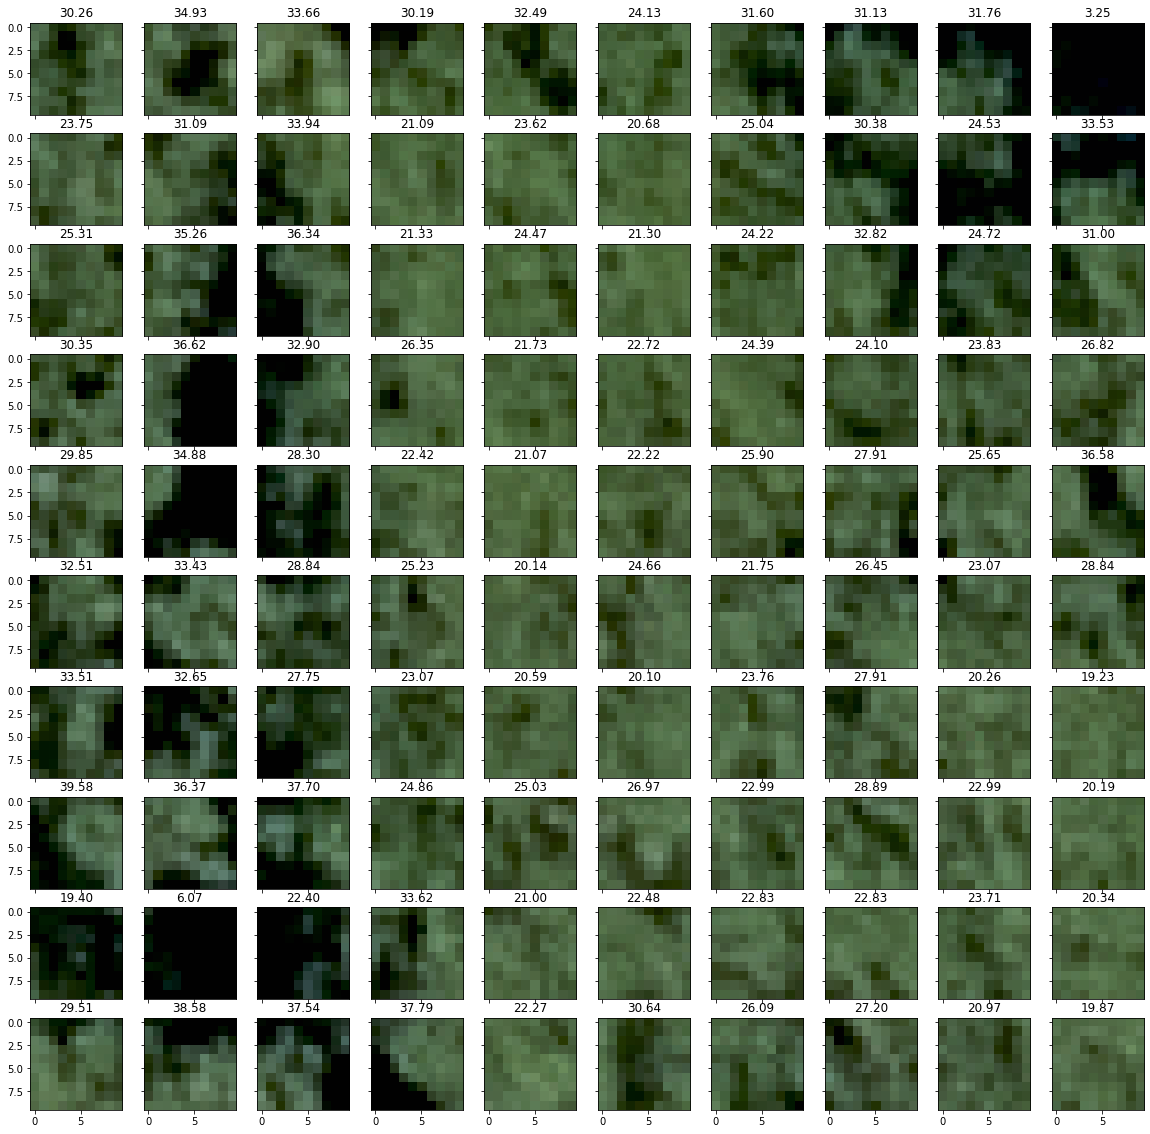

In [40]:
plot_window_stddev(10,10,500)

From above experiments on forested and non-forested areas, the stddev threshold is around 20

In [85]:
def calc_window_stddev(n, window_size, offset, should_print):
    for y in range(offset,n+offset):
        for x in range(offset,n+offset):
            r = image[y*window_size:(y+1)*window_size, x*window_size:(x+1)*window_size, 0:3]
            stddev = r.std()
            if should_print:
                print("{:.2f}".format(stddev), end=",")  

In [86]:
startTime = datetime.now()
calc_window_stddev(1000,10,0,False)
print(datetime.now() - startTime)

0:00:51.285241


In [90]:
calc_window_stddev(100,100,10,False) 

(10000, 10000, 3) uint8


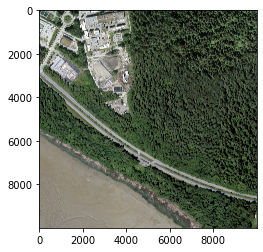

In [14]:
os.chdir(os.path.join(et.io.HOME, "ubc/capstone/orthophoto/2014"))
image = imageio.imread('483E_5454N.tif')
type(image)
print(image.shape, image.dtype)
plt.imshow(image)

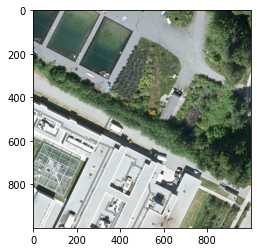

In [15]:
plt.imshow(image[0:1000,0:1000,:])

In [10]:
def stddev_above_threshold(x,y,window_size, threshold,im):
    r = im[x*window_size:(x+1)*window_size, y*window_size:(y+1)*window_size, 0:3]
    return r.std() > threshold
def green_threshold(x,y,green_threshold,other_threshold,im):
    return im[x,y,1] > green_threshold and im[x,y,0] < other_threshold and im[x,y,2] < other_threshold 

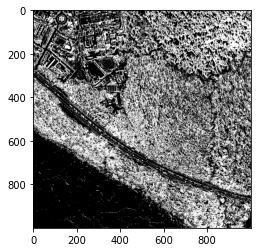

In [12]:
n = 1000
stddev_array = np.array([stddev_above_threshold(i//n,i%n,10,25,image) for i in range(0,n**2)]).reshape(n,n)
plt.imshow(stddev_array, cmap=plt.cm.gray)

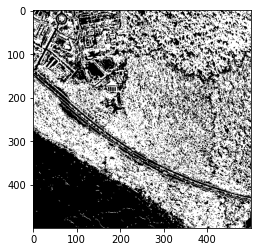

In [15]:
n = 500
stddev_array = np.array([stddev_above_threshold(i//n,i%n,20,25,image) for i in range(0,n**2)]).reshape(n,n)
plt.imshow(stddev_array, cmap=plt.cm.gray)

0:00:02.289517


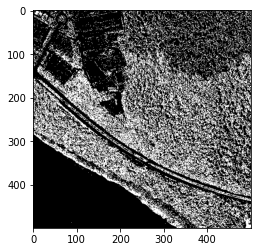

In [36]:
n = 500
def green_threshold_window(x,y,window_size,green_threshold,other_threshold,im):
    pixel = im[x*window_size,y*window_size,:]
    return pixel[1] > green_threshold and pixel[0] < other_threshold and pixel[2] < other_threshold 
startTime = datetime.now()
green_array = np.array([green_threshold_window(i//n,i%n,20,70,100,image) for i in range(0,n**2)]).reshape(n,n)
plt.imsave("green.png", green_array)
plt.imshow(green_array, cmap=plt.cm.gray)
print(datetime.now() - startTime)

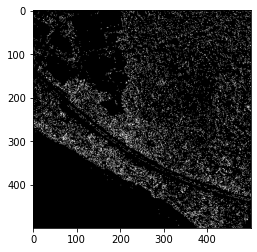

In [31]:
n=500
green_stddev_array = np.array([green_array[i//n,i%n] and stddev_array[i//n,i%n] for i in range(0,n**2)]).reshape(n,n)
plt.imsave("stddev.png", stddev_array)
plt.imsave("green_stddev.png", green_stddev_array)
plt.imshow(green_stddev_array,cmap=plt.cm.gray)

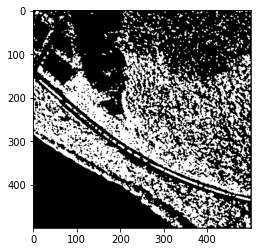

In [35]:
close_img = ndimage.binary_closing(green_array)
plt.imshow(close_img, cmap=plt.cm.gray)
open_img = ndimage.binary_opening(close_img)
plt.imshow(open_img, cmap=plt.cm.gray)



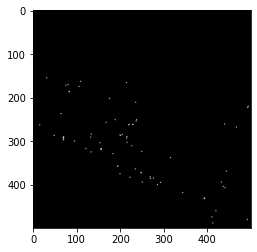

In [28]:
open_img = ndimage.binary_opening(green_stddev_array)
plt.imshow(open_img, cmap=plt.cm.gray)
close_img = ndimage.binary_closing(open_img)
plt.imshow(close_img, cmap=plt.cm.gray)


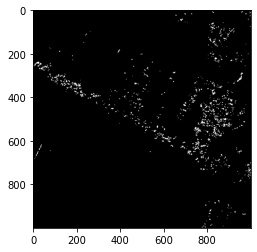

In [81]:
close_img = ndimage.binary_closing(open_img)
plt.imshow(close_img, cmap=plt.cm.gray)
open_img = ndimage.binary_opening(close_img)
plt.imshow(open_img, cmap=plt.cm.gray)

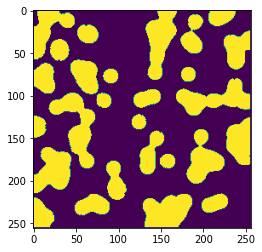

In [34]:
def segmentation_example():
    n = 10
    l = 256
    im = np.zeros((l, l))
    np.random.seed(1)
    points = l*np.random.random((2, n**2))
    im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    im = ndimage.gaussian_filter(im, sigma=l/(4.*n))

    mask = (im > im.mean()).astype(np.float)
    mask += 0.1 * im
    img = mask + 0.2*np.random.randn(*mask.shape)

    hist, bin_edges = np.histogram(img, bins=60)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

    binary_img = img > 0.5

    open_img = ndimage.binary_opening(binary_img)
    plt.imshow(open_img)
    close_img = ndimage.binary_closing(open_img)
    plt.imshow(close_img)
segmentation_example()

In [ ]:
image = imageio.imread('483E_5454N.tif')
